In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KernelDensity
from sklearn.decomposition import PCA

In [2]:
def timestamp2date(timestamp):
    """Convert timestamp to datetime."""
    timeArray = time.localtime(timestamp)
    formatted_time = time.strftime("%Y-%m-%d %H:%M:%S", timeArray)
    return formatted_time
def get_tgAcceleration(df):
    """Calculate tangential acceleration."""
    dVehSpdLgtA = df["VehSpdLgtA"].diff() / 3.6
    dt = df["t"].diff()
    df["tg_acceleration"] = dVehSpdLgtA / dt
    return df
def kde2D(x, y, bandwidth, xbins=10j, ybins=10j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""
    
    # create grid of sample locations (default: 10x10)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    zz = np.reshape(z, xx.shape)
    z_norm = z / z.sum()
    z_norm= z_norm.ravel()
    return xx,yy,zz,z_norm

In [3]:
# read data
df = pd.read_csv(r"D:\Research\UBI车险\data\486_wuhan_test - LT.csv")
df[3716:3725]

,t,VehSpdLgtA
3716,1664774464,1.466075
3717,1664774465,2.290549
3718,1664774466,3.062756
3719,1664774467,3.619785
3720,1664774468,4.029551
3721,1664774469,4.158022
3722,1664774470,4.267677
3723,1664774471,4.304910
3724,1664774472,4.054787


In [4]:
# convert timestamp
df["date"] = df["t"].apply(timestamp2date)

In [5]:
# convert m/s to km/h
df["VehSpdLgtA"] = df["VehSpdLgtA"] * 3.6
df = df[["t","date","VehSpdLgtA"]]
df[3716:3725]

,t,date,VehSpdLgtA
3716,1664774464,2022-10-03 13:21:04,5.277870
3717,1664774465,2022-10-03 13:21:05,8.245977
3718,1664774466,2022-10-03 13:21:06,11.025920
3719,1664774467,2022-10-03 13:21:07,13.031225
3720,1664774468,2022-10-03 13:21:08,14.506384
3721,1664774469,2022-10-03 13:21:09,14.968881
3722,1664774470,2022-10-03 13:21:10,15.363639
3723,1664774471,2022-10-03 13:21:11,15.497676
3724,1664774472,2022-10-03 13:21:12,14.597232


In [6]:
# drop reduplicative records
df = df.drop_duplicates(subset = ["t"]).sort_values(by = ["t"]).reset_index(drop = True)

In [7]:
# partition journey
df["dt"] = df["t"].diff()
df["stop"] = df["dt"] != 1
df["journeyID"] = df["stop"].cumsum()
df.loc[df["dt"] != 1].head(5)

,t,date,VehSpdLgtA,dt,stop,journeyID
0,1664771299,2022-10-03 12:28:19,0.00000,NaN,True,1
3432,1664774743,2022-10-03 13:25:43,30.22668,13.0,True,2
18852,1664790168,2022-10-03 17:42:48,0.00000,6.0,True,3
18867,1664790201,2022-10-03 17:43:21,0.00000,19.0,True,4
18872,1664790352,2022-10-03 17:45:52,0.00000,147.0,True,5


In [8]:
# interpolate speed
df["VehSpdLgtA"] = df.groupby("journeyID")["VehSpdLgtA"].apply(lambda v: v.interpolate(limit_direction = "both"))
df["VehSpdLgtA"] = df["VehSpdLgtA"].fillna(0)
df.isnull().sum()

t             0
date          0
VehSpdLgtA    0
dt            1
stop          0
journeyID     0
dtype: int64

In [9]:
# calculate tangential acceleration
df = df.groupby("journeyID").apply(get_tgAcceleration)

In [10]:
# omit the first row of every journey (beacause of NaN of tg_acceleration)
df = df.groupby("journeyID").apply(lambda x:x.iloc[1:]).reset_index(drop = True)

In [11]:
# omit meaningless journeies(v == 0 or cumsum(t) less than 3min)
df["is_meaningless"] = df.groupby("journeyID")["VehSpdLgtA"].transform(lambda v: True if (np.sum(v) == 0 or len(v) < 3 * 60) else False)
df = df[~df["is_meaningless"]].reset_index(drop = True)
df = df[["t","date","journeyID","VehSpdLgtA","tg_acceleration"]]
df[3432 - 5:3432 + 5]

,t,date,journeyID,VehSpdLgtA,tg_acceleration
3427,1664774727,2022-10-03 13:25:27,1,5.174085,0.271833
3428,1664774728,2022-10-03 13:25:28,1,8.539653,0.934880
3429,1664774729,2022-10-03 13:25:29,1,14.401429,1.628271
3430,1664774730,2022-10-03 13:25:30,1,21.543003,1.983771
3431,1664774744,2022-10-03 13:25:44,2,35.965230,1.594042
3432,1664774745,2022-10-03 13:25:45,2,41.562016,1.554663
3433,1664774746,2022-10-03 13:25:46,2,45.233653,1.019899
3434,1664774747,2022-10-03 13:25:47,2,47.595998,0.656207
3435,1664774748,2022-10-03 13:25:48,2,49.609496,0.559305
3436,1664774749,2022-10-03 13:25:49,2,51.091188,0.411581


In [12]:
# kernel density analysis
results = df.groupby("journeyID").apply(lambda x:kde2D(x["VehSpdLgtA"],x["tg_acceleration"],bandwidth = 0.75))
results = [{"journeyID":index, "z_norm":results[index][3]} for index in results.index]
z_norms = pd.DataFrame(results)
z_norms = pd.DataFrame(z_norms["z_norm"].to_list(),columns = ["z_norm" + str(i) for i in range(1,101)])
mean = z_norms.mean(axis = 0)
std = z_norms.std(axis = 0)
z_norms = (z_norms - mean)/std
z_norms 

,z_norm1,z_norm2,z_norm3,z_norm4,z_norm5,z_norm6,z_norm7,z_norm8,z_norm9,z_norm10,...,z_norm91,z_norm92,z_norm93,z_norm94,z_norm95,z_norm96,z_norm97,z_norm98,z_norm99,z_norm100
0,1.150882,2.105599,2.226568,1.323069,0.550375,-0.191739,-0.202569,0.648873,0.482447,-0.084785,...,0.161078,-0.103173,-0.224668,-0.295690,-0.367799,-0.487362,-0.615545,-0.485786,-0.013339,0.061421
1,-0.519455,-0.627270,-0.840208,-0.980981,-0.373241,1.431938,1.193905,0.721980,-0.433778,-0.377328,...,-0.561219,-0.413238,-0.385991,-0.391768,-0.356853,-0.213476,-0.133778,-0.448526,-0.932729,-0.636336
2,-0.512818,-0.550073,-0.378237,0.187938,1.003682,0.946524,0.082148,-0.406777,-0.467004,-0.373390,...,-0.558469,-0.401397,-0.350619,-0.321288,-0.307578,-0.368025,-0.534604,-0.666523,-0.754136,-0.550312
3,-0.517598,-0.602879,-0.682812,-0.585139,-0.202958,0.266004,0.287673,0.694398,-0.128903,-0.342511,...,-0.561116,-0.412622,-0.383669,-0.392397,-0.409884,-0.423440,-0.348356,0.053722,0.667329,0.199289
4,-0.504553,-0.552983,-0.567088,-0.526044,-0.507043,-0.555184,-0.363984,-0.247357,-0.266258,-0.343904,...,-0.546032,-0.371986,-0.292271,-0.206047,-0.058931,0.213884,0.757887,1.642983,1.765139,0.111615
5,-0.294788,0.186079,0.780550,0.699388,0.173068,-0.721019,-0.795685,-1.199904,-0.524406,-0.370464,...,2.309967,2.645624,2.662781,2.660997,2.648345,2.596513,2.340022,1.726476,0.499628,-0.402535
6,-0.517356,-0.545852,0.052200,1.583878,1.799248,-0.631687,-1.227170,-1.864141,-0.654022,-0.381637,...,-0.560185,-0.403328,-0.339810,-0.281325,-0.270486,-0.431517,-0.772085,-1.034387,-1.108378,-0.643357
7,-0.519442,-0.627198,-0.851794,-1.156288,-1.206973,1.063727,1.863118,1.010843,-0.518444,-0.380713,...,-0.561220,-0.413301,-0.387469,-0.408758,-0.439271,-0.310394,0.046515,-0.227863,-0.931904,-0.639947
8,2.235128,1.214576,0.260821,-0.545821,-1.236158,-1.608565,-0.837436,0.642085,2.510368,2.654731,...,0.877197,-0.126580,-0.298283,-0.363725,-0.437543,-0.576184,-0.740056,-0.560097,0.808392,2.500162


In [13]:
# principal components analysis
pca = PCA(n_components = 5)
pca.fit(z_norms)
print("explained_variance_ratio_: ",pca.explained_variance_ratio_)
print("cummulative explained_variance_ratio_: ",np.cumsum(pca.explained_variance_ratio_))
pca_score = np.dot(z_norms,pca.components_.T)
pca_score

explained_variance_ratio_:  [0.31096422 0.24764123 0.21207168 0.10136821 0.06220437]
cummulative explained_variance_ratio_:  [0.31096422 0.55860544 0.77067713 0.87204533 0.93424971]


array([[ 2.41141437, -1.41412206, -5.19764126,  0.92121848,  4.96106151],
       [-1.38411456, -5.05955762, -0.45050402, -1.54329948, -0.11656773],
       [ 1.12499564, -3.30445465, -2.11591087,  2.38016697, -1.78984455],
       [-3.94085388, -0.56989959,  4.13484238,  0.15234431,  3.15567455],
       [-5.72932325,  2.89341151,  7.96844037,  2.20092963, -0.30329027],
       [-4.82882962,  9.56774199, -5.32435834, -3.34642376, -0.88304455],
       [-0.2716431 , -0.38782568, -3.68314681,  5.28391713, -2.64809597],
       [-0.33976152, -6.23468876,  0.824487  , -5.25142117, -1.98461308],
       [12.95811592,  4.50939486,  3.84379157, -0.79743211, -0.3912799 ]])

<AxesSubplot:>

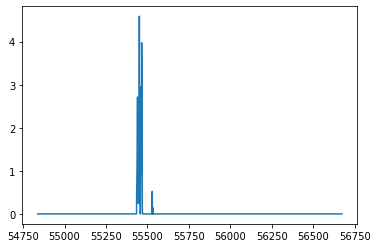

In [22]:
# speed visualize
df_vis = df[df["journeyID"] == 37]
df_vis["VehSpdLgtA"].plot()

Text(0, 0.5, 'tg_acceleration')

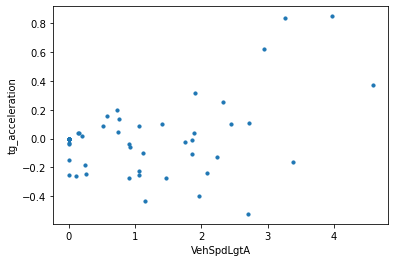

In [23]:
# speed-acceleration visualize
ax_1 = plt.scatter(df_vis["VehSpdLgtA"],df_vis["tg_acceleration"],s = 10)
plt.xlabel("VehSpdLgtA")
plt.ylabel("tg_acceleration")

C:\Users\lenovo\AppData\Local\Temp/ipykernel_14300/3888289793.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(xx, yy, zz)


Text(0, 0.5, 'tg_acceleration')

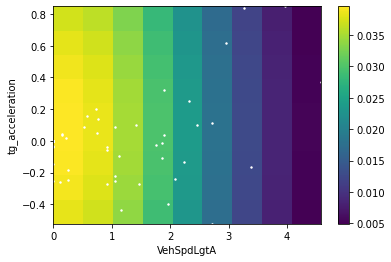

In [24]:
# kernel density visualize
x,y = df_vis["VehSpdLgtA"],df_vis["tg_acceleration"]
xx,yy,zz,z_norm = kde2D(x,y,bandwidth = 2)
plt.pcolormesh(xx, yy, zz)
plt.colorbar()
plt.scatter(x, y, s=2, facecolor='white')
plt.xlabel("VehSpdLgtA")
plt.ylabel("tg_acceleration")

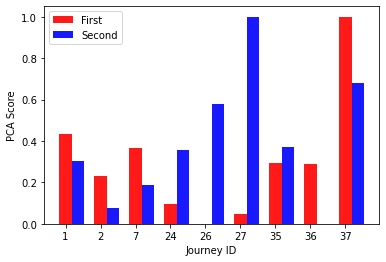

In [25]:
# principal components visualize
journeyID_num = len([result["journeyID"] for result in results])
labels = [str(result["journeyID"]) for result in results]
X = np.arange(journeyID_num) + 1

first_PCA_score = (pca_score[:,0] - pca_score[:,0].min()) / (pca_score[:,0].max() - pca_score[:,0].min())
second_PCA_score = (pca_score[:,1] - pca_score[:,1].min()) / (pca_score[:,1].max() - pca_score[:,1].min())

plt.bar(X,first_PCA_score,width = 0.35,alpha = 0.9,facecolor = "red",label = "First")
plt.bar(X + 0.35,second_PCA_score,width = 0.35,alpha = 0.9, facecolor = "blue",label = "Second")
plt.xlabel("Journey ID")
plt.ylabel("PCA Score")
plt.xticks(X,labels)
plt.legend()
plt.show()